**IMPORTS:**

In [ ]:
! [ -e /content ] && pip install -Uqq fastai

     |████████████████████████████████| 197 kB 21.8 MB/s 
     |████████████████████████████████| 60 kB 6.5 MB/s 


In [ ]:
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastdownload import download_url

In [ ]:
!pip install fastinference

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


Upload your kaggle.json file to the session

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

**DATASET DOWNLOAD:**

In [ ]:
! kaggle datasets download jonathanoheix/face-expression-recognition-dataset

face-expression-recognition-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
from zipfile import ZipFile
zip = ZipFile('file.zip')
zip.extractall()

In [ ]:
path=('images/train')

In [ ]:
fns=get_image_files(path)
len(fns)

28821

**DATABLOCK CREATION:**

In [ ]:
db=DataBlock(
    
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2,seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

In [ ]:
dls=db.dataloaders(path)

**7 Classes:**

In [ ]:
dls.vocab

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

**SAMPLE:**

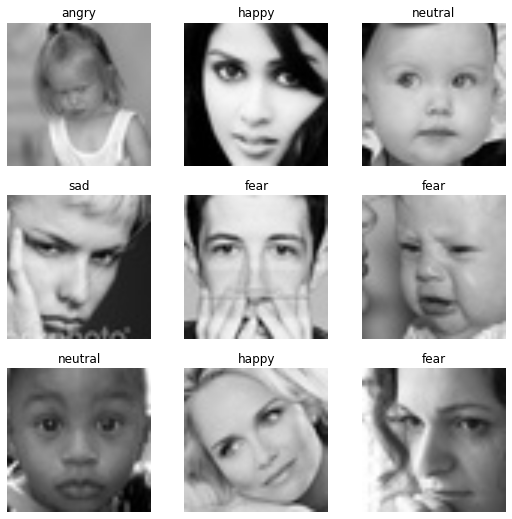

In [ ]:
dls.show_batch(nrows=3,ncols=3)

**FINDING AN LR FOR A resnet34 model:**

Comparing the loss fn

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

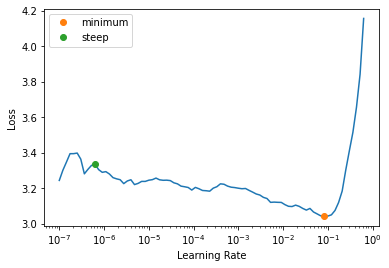

In [ ]:
model = vision_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = model.lr_find(suggest_funcs=(minimum, steep))

**FINDING AN LR FOR A resnet50 model:**

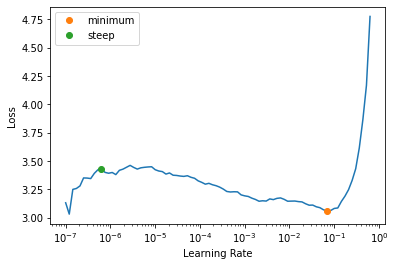

In [ ]:
model = vision_learner(dls, resnet50, metrics=error_rate)
lr_min,lr_steep = model.lr_find(suggest_funcs=(minimum, steep))

In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 6.92e-03, steepest point: 6.31e-07


**TRAINING WITH AN LR RANGE:**

In [ ]:
model.fit_one_cycle(12, lr_max=slice(1e-5,6.92e-3))

epoch,train_loss,valid_loss,error_rate,time
0,1.857814,1.571740,0.597849,02:29
1,1.588685,1.483729,0.564539,02:28
2,1.417071,1.362381,0.516829,02:29
3,1.250286,1.245726,0.466516,02:28
4,1.182975,1.203739,0.451423,02:28
5,1.082686,1.203118,0.447779,02:28
6,0.994859,1.191543,0.432686,02:28
7,0.906564,1.193183,0.428348,02:29
8,0.814893,1.213900,0.430257,02:28
9,0.725301,1.232784,0.422103,02:28


In [ ]:
model.unfreeze()

**CONFUSION MATRIX FOR ANALYSIS:**

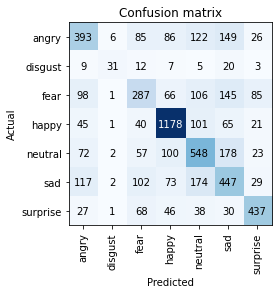

In [ ]:
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix()

**IMAGES WITH HIGHEST LOSS:**

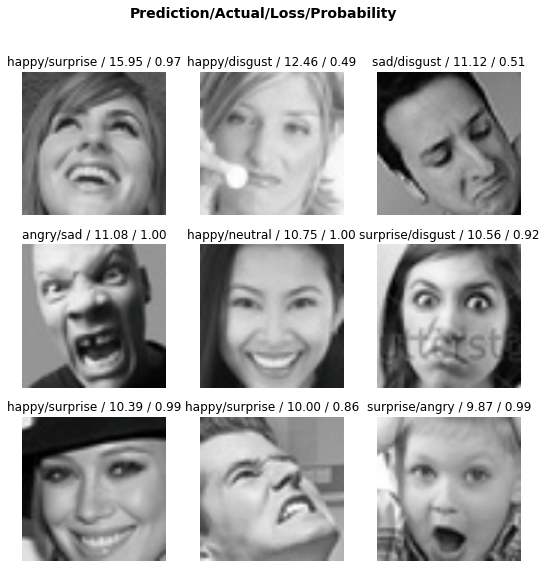

In [ ]:
interp.plot_top_losses(15, nrows=3)

**DATA CLEANING:**

fastai's GUI

In [ ]:
cleaner = ImageClassifierCleaner(model)
cleaner

**RETRAINING WITH A NEW LR:**

Minimum/10: 1.91e-07, steepest point: 7.59e-07


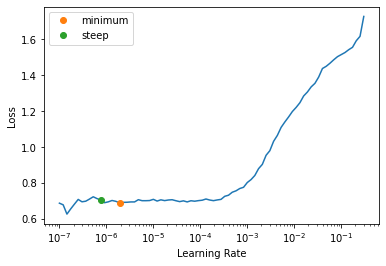

In [ ]:
lr_min1,lr_steep1 = model.lr_find(suggest_funcs=(minimum, steep))
print(f"Minimum/10: {lr_min1:.2e}, steepest point: {lr_steep1:.2e}")

In [ ]:
model.fit_one_cycle(8, lr_max=slice(7.59e-07,1.91e-07))

epoch,train_loss,valid_loss,error_rate,time
0,0.656974,1.244041,0.422103,03:07
1,0.660742,1.248258,0.425226,03:10
2,0.651587,1.247415,0.420715,03:08
3,0.621823,1.242169,0.424185,03:07
4,0.631284,1.243932,0.422797,03:07
5,0.608471,1.239507,0.417939,03:19
6,0.627627,1.249870,0.424185,03:06
7,0.638278,1.243739,0.420368,03:20


**RETRAINING WITH LABEL SMOOTHING:**

As data is not perfectly labelled, label smoothin aims to improve the accuracy.
But for significant improvements, more epoches have to be trained.

In [ ]:
model1 = vision_learner(dls, resnet50,loss_func=LabelSmoothingCrossEntropy(), metrics=error_rate)
model1.fine_tune(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.854463,1.618013,0.582755,02:32


epoch,train_loss,valid_loss,error_rate,time
0,1.401849,1.334804,0.425746,03:08
1,1.223786,1.292244,0.404580,03:07
2,1.040592,1.319234,0.395732,03:07
3,0.754262,1.372941,0.383935,03:07
4,0.579348,1.336916,0.365545,03:07
5,0.502789,1.315939,0.361381,03:07
6,0.476968,1.298175,0.355135,03:07
7,0.467907,1.287613,0.355309,03:07


**EXPORT:**

In [ ]:
model1.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

**Inference:**

In [ ]:
#inf= load_learner(path/'export.pkl')